# Introduction Azure ML service
<br>

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>


> Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/

## 0. Paramétrage

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import datetime
now = datetime.datetime.now()
print(now)

2019-12-16 13:29:12.367976


In [3]:
import azureml.core
from azureml.core import Experiment, Workspace

# Check core SDK version number
print("Version Azure ML service : ", azureml.core.VERSION)

Version Azure ML service :  1.0.76


In [4]:
# Rappel des infos du workspace Azure ML service
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Resource group: ' + ws.resource_group, sep='\n')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code CYBBMNLSF to authenticate.
Interactive authentication successfully completed.
Workspace name: workshopml
Azure region: westeurope
Resource group: workshopmlRG


## 1. Chargement des données

In [5]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

In [6]:
X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [7]:
# Partitionnement des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

In [8]:
print ("Training =", len(data['train']['X']), 'observations')

Training = 353 observations


In [9]:
print ("Test =", len(data['test']['X']), 'observations')

Test = 89 observations


## 2. Modélisation

Nous allons réaliser un modèle de régression **Ridge**.<br> 
<img src='https://github.com/retkowsky/images/blob/master/ridge.png?raw=true'>
<br>
C'est une version régularisée de la régression linéaire.
Cela permet d'ajuster les données avec des coefficents de pondération du modèle les plus petits possibles.
- Si le paramétre = 0 => nous avons dans ce cas une régression linéaire.
- Si le paramétre a une valeur importante, alors les coefficients de pondérations ont des valeurs proches de 0 => on aura dans ce cas une ligne horizontale qui passe par la moyenne des données.



In [10]:
experiment = Experiment(workspace=ws, name="workshop1-IntroductionAMLS")

Les étapes
1. Logs d'informations
2. Modélisation
3. Logs de résultats de modèles
4. Sauvegarde modèle

In [11]:
def regridge(alpha):
    
    from datetime import datetime
    maintenant = datetime.now()
    print("Maintenant : ", maintenant)

    # 1. Run
    run = experiment.start_logging()
    print('Alpha = ', alpha)
    
    # 2. Logs de valeurs
    run.log('alpha', alpha)
    run.log('date_log', str(maintenant))

    # 3. Modèle ML
    regression_model = Ridge(alpha=alpha)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    # 4. Log des métriques
    print('MSE ou Mean Squared Error du modèle =', mean_squared_error(data['test']['y'], preds))
    run.log('mse', mean_squared_error(data['test']['y'], preds))

    # 5. Export modèle
    joblib.dump(value=regression_model, filename='modelenotebook1.pkl')

    # 6. Ajout de tags au run
    run.tag("Langage", "Python")
    run.tag("Version_Python", "3.6.9")
    run.tag("Version_AMLS", "1.0.74")
    run.tag("Team", "DataScience")
    run.tag("Pays", "France") 
    run.tag("Auteur", "Serge") 
    
    # 6. Fin
    run.complete()

Rappel: Définition MSE
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/e258221518869aa1c6561bb75b99476c4734108e">

In [12]:
regridge(0.1)

Maintenant :  2019-12-16 13:31:37.208753
Alpha =  0.1
MSE ou Mean Squared Error du modèle = 3372.649627810032


In [13]:
regridge(0.2)

Maintenant :  2019-12-16 13:32:30.478179
Alpha =  0.2
MSE ou Mean Squared Error du modèle = 3325.2946794678764


In [14]:
regridge(0.3)

Maintenant :  2019-12-16 13:32:53.267081
Alpha =  0.3
MSE ou Mean Squared Error du modèle = 3302.6736334017255


In [15]:
# On regarde si on a bien téléchargé le pickle du modèle
%ls modelenotebook1.pkl -l

-rwxrwxrwx 1 root root 645 Dec 16 13:33 modelenotebook1.pkl*


> Nous pouvons visualiser les résultats sur le portail dans la section **experiments**

## 3. Création d'une seconde expérimentation

In [16]:
experiment = Experiment(workspace=ws, name="workshop1-IntroductionAMLS2")

### Boucle sur le paramètre alpha

In [17]:
%%time
import numpy as np
from tqdm import tqdm

# On boucle par pas de 0.05 entre 0 et 1
alphas = np.arange(0.0, 1.0, 0.05)

# try a bunch of alpha values in a Linear Regression (Ridge) model
for alpha in tqdm(alphas):
    # create a bunch of runs, each train a model with a different alpha value
    with experiment.start_logging() as run:
        # Use Ridge algorithm to build a regression model
        alpha=round(alpha, 2)
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X=data["train"]["X"], y=data["train"]["y"])
        preds = regression_model.predict(X=data["test"]["X"])
        mse = mean_squared_error(y_true=data["test"]["y"], y_pred=preds)
        mse=round(mse, 2)
        # log alpha, mean_squared_error and feature names in run history
        run.log(name="alpha", value=alpha)
        run.log(name="mse", value=mse)
        
        # Génération pickle du modèle
        model_name = "modele_ridge_alpha_" + str(round(alpha, 2)) + ".pkl"
        filename = "outputs/" + model_name
    
        # Save the model to the outputs directory for capture
        joblib.dump(value=regression_model, filename=filename)
        
        # Tags
        run.tag("Langage", "Python")
        run.tag("Version_Python", "3.6.9")
        run.tag("Version_AMLS", "1.0.74")
        run.tag("Team", "DataScience")
        run.tag("Pays", "France") 
        run.tag("Auteur", "Franck") 

100%|██████████| 20/20 [07:40<00:00, 23.04s/it]

CPU times: user 14.7 s, sys: 5.96 s, total: 20.7 s
Wall time: 7min 40s


### Accés direct au portail

In [26]:
experiment

Experiment(Name: workshop1-IntroductionAMLS2,
Workspace: workshopml)

In [27]:
runs = {}
run_metrics = {}

# Create dictionaries containing the runs and the metrics for all runs containing the 'mse' metric
for r in tqdm(experiment.get_runs()):
    metrics = r.get_metrics()
    if 'mse' in metrics.keys():
        runs[r.id] = r
        run_metrics[r.id] = metrics

# Find the run with the best (lowest) mean squared error and display the id and metrics
best_run_id = min(run_metrics, key = lambda k: run_metrics[k]['mse'])
best_run = runs[best_run_id]

print('>> Métriques du meilleur Run = ', run_metrics[best_run_id])
print('>> ID du meilleur Run =', best_run_id)

60it [00:08,  6.90it/s]

>> Métriques du meilleur Run =  {'alpha': 0.4, 'mse': 3295.74}
>> ID du meilleur Run = 4ff74200-88cd-4eaa-a5a7-87eef12974e3


In [28]:
experiment

Experiment(Name: workshop1-IntroductionAMLS2,
Workspace: workshopml)

### J'enregistre le meilleur modèle dans le repository de modèle Azure ML service

In [29]:
model = best_run.register_model(model_name='meilleur_modele_ridge', model_path='outputs/modele_ridge_alpha_0.4.pkl')

### Je visualise le modèle et la version associée

In [30]:
from azureml.core.model import Model
models = Model.list(ws, name='meilleur_modele_ridge')
for m in models:
    print("Modèle :",m.name, "- version =", m.version)

Modèle : meilleur_modele_ridge - version = 4
Modèle : meilleur_modele_ridge - version = 3
Modèle : meilleur_modele_ridge - version = 2
Modèle : meilleur_modele_ridge - version = 1


### On télécharge en local le pickle du modèle

In [31]:
best_run.download_file(name="outputs/modele_ridge_alpha_0.4.pkl")

### On regarde si le fichier a bien été téléchargé en local (ici la VM notebook)

In [32]:
%ls modele_ridge_*.pkl -l

-rwxrwxrwx 1 root root 658 Dec 16 13:42 modele_ridge_alpha_0.4.pkl*


## 4. Utilisation MLFlow

<img src="https://docs.microsoft.com/en-us/azure/machine-learning/service/media/how-to-use-mlflow/mlflow-diagram-track.png">

Documentation: https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-use-mlflow

> https://mlflow.org/

In [33]:
import mlflow
import mlflow.sklearn
import azureml.core
from azureml.core import Workspace
import matplotlib.pyplot as plt

In [34]:
#pip install azureml-mlflow

In [35]:
ws = Workspace.from_config()

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

experiment_name = "MLFlow"
mlflow.set_experiment(experiment_name)

INFO: 'MLFlow' does not exist. Creating a new experiment


Data contains 353 training samples and 89 test samples
Mean Squared Error is 3295.741064355809


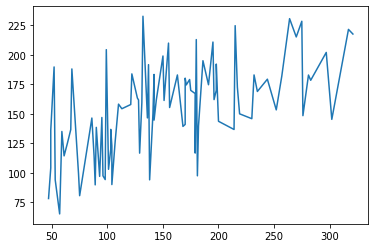

In [37]:
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y = True)
columns = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
data = {
    "train":{"X": X_train, "y": y_train},        
    "test":{"X": X_test, "y": y_test}
}

print ("Data contains", len(data['train']['X']), "training samples and",len(data['test']['X']), "test samples")

model_save_path = "model"

with mlflow.start_run() as run:
    # Log the algorithm parameter alpha to the run
    mlflow.log_metric('alpha', 0.4)
    # Create, fit, and test the scikit-learn Ridge regression model
    regression_model = Ridge(alpha=0.4)
    regression_model.fit(data['train']['X'], data['train']['y'])
    preds = regression_model.predict(data['test']['X'])

    # Log mean squared error
    print('Mean Squared Error is', mean_squared_error(data['test']['y'], preds))
    mlflow.log_metric('mse', mean_squared_error(data['test']['y'], preds))
    
    # Save the model to the outputs directory for capture
    mlflow.sklearn.log_model(regression_model,model_save_path)
    
    # Plot actuals vs predictions and save the plot within the run
    fig = plt.figure(1)
    idx = np.argsort(data['test']['y'])
    plt.plot(data['test']['y'][idx],preds[idx])
    fig.savefig("actuals_vs_predictions.png")
    mlflow.log_artifact("actuals_vs_predictions.png")
    

In [38]:
ws.experiments[experiment_name]

Experiment(Name: MLFlow,
Workspace: workshopml)

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">